In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import json
import pickle
from modules.functions import data_generator_vec, get_comp
from matplotlib.cm import ScalarMappable

/noether/s0/aqd5773/anaconda3/envs/uts_candidates/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Directory for saving figures

In [3]:
fig_location = 'figures'
if not os.path.exists(fig_location):
    os.mkdir(fig_location)

## Dataset analysis

In [7]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)

In [10]:
import pymatgen.core as mg
def get_number_of_components(comp_list):
  count_list = []
  for c in comp_list:
    if not type(c) == mg.Composition:
      c = mg.Composition(c)
      count_list.append(len(list(c.get_el_amt_dict().keys())))
  return count_list

c = get_number_of_components(dataset['Composition'])
np.min(c), np.max(c), np.median(c)


(2, 6, 5.0)

In [4]:
dict_els = {}
for i in dataset['Composition'].values:
    el_list = re.findall('[A-Z][a-z]?', i)
    for el in el_list:
        if el in dict_els.keys():
            dict_els[el] += 1
        else:
            dict_els[el] = 1

Text(0.5, 1.0, 'Element count in reduced dataset')

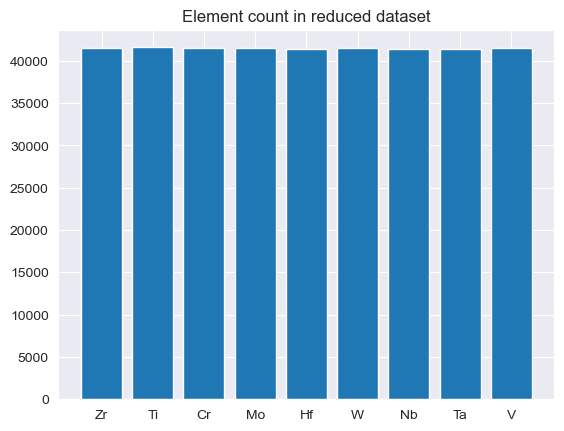

In [5]:
plt.bar(range(len(dict_els.keys())),list(dict_els.values()))
plt.xticks(range(len(dict_els.keys())),list(dict_els.keys()))
plt.title('Element count in reduced dataset')

# Results

### Single property

In [4]:
with open('results.json','r') as fid:
    results_dict = json.load(fid)

el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/starting_comp.json','r') as fid:
    start_comp_dict = json.load(fid)

with open('misc/hts_result.pkl','rb') as fid:
    hts_dict = pickle.load(fid)

start_comp = start_comp_dict['start_comp']

In [5]:
inv_inc_comps = np.array(results_dict['inverse']['inc']['g_fake_data'])
inv_fixed_comps =  np.array(results_dict['inverse']['fixed']['g_fake_data'])
forward_comps = np.array(results_dict['forward']['best_cands'])
hts_comps = np.array(hts_dict['all_comps'])[::-1]
hts_comps = np.concatenate((hts_comps, np.array(start_comp).reshape(1,-1)))

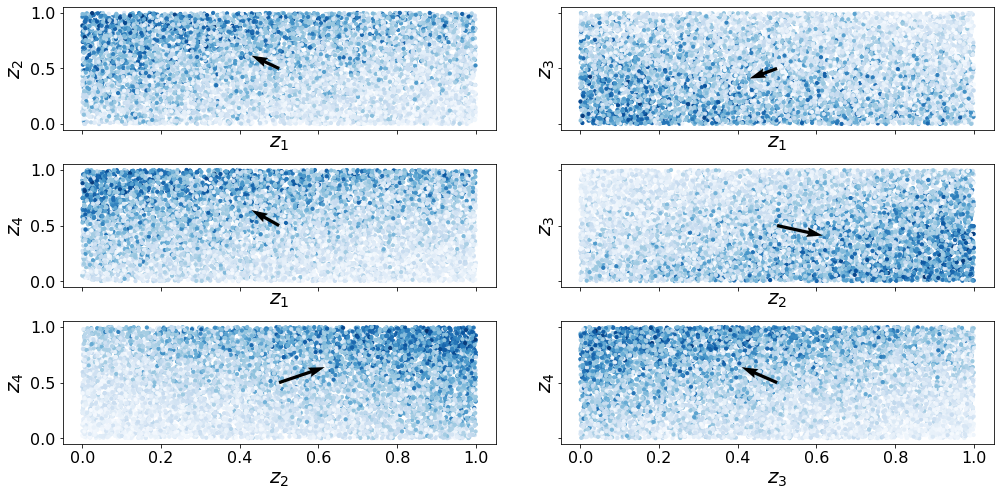

In [7]:
uniform_noise = np.array(results_dict['inverse']['constants']['uniform_noise'])
w_content =  np.array(results_dict['inverse']['constants']['w_content'])
dominant_dir = np.array(results_dict['inverse']['constants']['dominant_dir'])

from itertools import combinations
perm = combinations(np.arange(uniform_noise.shape[1]), 2)  
fig,ax = plt.subplots(3,2,figsize = (14,7), sharex=True, sharey=True)
ax = ax.flatten()
for k,i in enumerate(list(perm)):
    a,b = i
    ax[k].scatter(uniform_noise[:,a],uniform_noise[:,b],s = 10, c = w_content[:],cmap = 'Blues')
    ax[k].quiver(0.5,0.5,dominant_dir[a],dominant_dir[b],angles='xy', scale_units='xy', scale=1)
    ax[k].set_xlabel('$z_{}$'.format(a+1), style = 'italic', fontsize=20)
    ax[k].set_ylabel('$z_{}$'.format(b+1), style = 'italic', fontsize=20)
    ax[k].tick_params(axis='both', which='major', labelsize=16)



#plt.suptitle('Direction of W variance in the latent dimensions')
plt.tight_layout()
fig.subplots_adjust(wspace=0.15)
plt.savefig(os.path.join(fig_location, 'concept_vector_latent_space.pdf'), bbox_inches="tight")

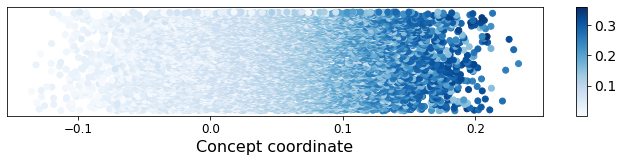

In [8]:
fig,ax = plt.subplots(figsize = (12,2))
cm = plt.cm.get_cmap('Blues')
sc = ax.scatter( np.dot(uniform_noise,dominant_dir),np.arange(len(uniform_noise)), c=w_content, cmap=cm)
ax.set_xlabel('Concept coordinate', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) 
ax.set_xticks(np.arange(-0.1,0.3,0.1))
cb = plt.colorbar(sc, aspect = 10)
for t in cb.ax.get_yticklabels():
            t.set_fontsize(14)
plt.savefig(os.path.join(fig_location, 'concept_vector_projection.pdf'), bbox_inches="tight")

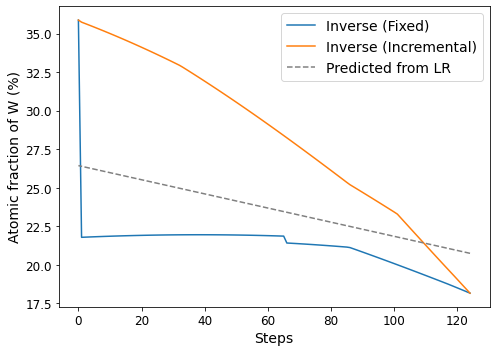

In [9]:
fig,ax = plt.subplots( figsize = (7,5))
fixed_bin = [True, False]
for bin in fixed_bin:
        
        i = int(bin)
        if bin:
            c = 'tab:orange'
            label = 'Inverse (Fixed)'
            new_predicted_w = np.array(results_dict['inverse']['fixed']['predicted_w']),
            gen_w_content = np.array(results_dict['inverse']['fixed']['actual_w']),
            g_fake_data_fixed = np.array(results_dict['inverse']['fixed']['g_fake_data']),
            g_fake_data_uts = np.array(results_dict['inverse']['fixed']['g_fake_data_uts']),
            y = np.array(results_dict['inverse']['fixed']['y']),
            n_points = np.array(results_dict['inverse']['fixed']['x'])
            
        else:
            c = 'tab:blue'
            label = 'Inverse (Incremental)'
            new_predicted_w = np.array(results_dict['inverse']['inc']['predicted_w']),
            gen_w_content = np.array(results_dict['inverse']['inc']['actual_w']),
            g_fake_data_fixed = np.array(results_dict['inverse']['inc']['g_fake_data']),
            g_fake_data_uts = np.array(results_dict['inverse']['inc']['g_fake_data_uts']),
            y = np.array(results_dict['inverse']['inc']['y']),
            n_points = np.array(results_dict['inverse']['inc']['x'])
        ax.plot(-100*n_points.reshape(-1),100*np.array(gen_w_content).reshape(-1), label = label)
        ax.tick_params(axis='both', which='major', labelsize=12)
ax.plot(-100*np.array(n_points).reshape(-1),100*np.array(new_predicted_w).reshape(-1), label = 'Predicted from LR', c = 'grey',linestyle='dashed')      
ax.set_xlabel('Steps', fontsize = 14)
ax.set_ylabel('Atomic fraction of W (%)', fontsize = 14)
ax.legend(fontsize = 14)

plt.tight_layout()
plt.savefig(os.path.join(fig_location, 'inverse_w_content_reduction.pdf'), bbox_inches="tight")


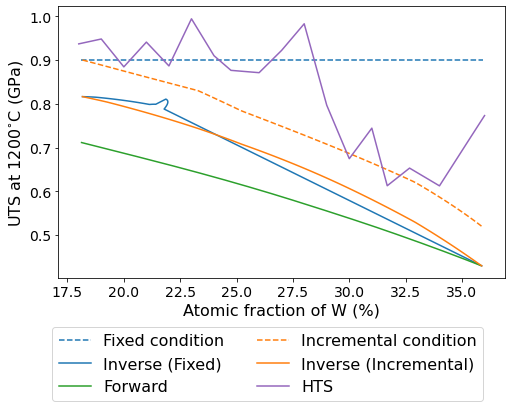

In [10]:
fig,ax = plt.subplots(figsize = (8,5))
inverse_uts_fixed = results_dict['inverse']['fixed']['g_fake_data_uts']
inverse_uts_inc = results_dict['inverse']['inc']['g_fake_data_uts']
inverse_w_fixed = np.array(results_dict['inverse']['fixed']['actual_w'])
inverse_w_inc = np.array(results_dict['inverse']['inc']['actual_w'])
forward_uts = results_dict['forward']['best_cand_uts']
forward_w = np.array(results_dict['forward']['w_content'])

hts_w = np.array(hts_dict['w_content_hts'])
hts_uts = hts_dict['uts_hts']
y = np.array(results_dict['inverse']['inc']['y'])
ax.axhline(y = 0.9, xmin = 0.05, xmax = 0.95, color = c, label = 'Fixed condition', linestyle = 'dashed', c = 'tab:blue')
ax.plot(100*inverse_w_fixed, inverse_uts_fixed, label = 'Inverse (Fixed)')


ax.plot(100*forward_w,forward_uts, label = 'Forward', c = 'tab:green')

ax.plot(100*inverse_w_inc, y, label = 'Incremental condition', linestyle = 'dashed', c = 'tab:orange')
ax.plot(100*inverse_w_inc, inverse_uts_inc, label = 'Inverse (Incremental)', c = 'tab:orange')

ax.plot(100*hts_w,hts_uts, label = 'HTS', c = 'tab:purple')


#plt.plot(p_front_univ[0], p_front_univ[1],linestyle = '--',linewidth=2,alpha=0.5, label='Global Pareto front')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Atomic fraction of W (%)', fontsize = 16)
ax.set_ylabel('UTS at $1200^{\circ}$C (GPa)', fontsize = 16)
plt.legend(fontsize =16,bbox_to_anchor = (-0.03, -0.15, 1, 0), ncol = 2)
plt.savefig(os.path.join(fig_location, 'uts_compare.pdf'), bbox_inches="tight")

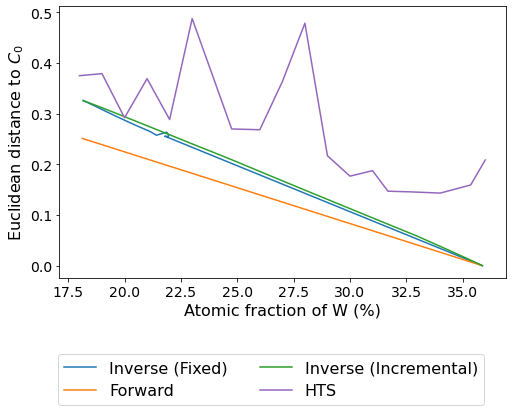

In [11]:
dist_inv_inc = [np.linalg.norm(x-np.array(start_comp)) for x in inv_inc_comps]
dist_inv_fixed = [np.linalg.norm(x-np.array(start_comp)) for x in inv_fixed_comps]
dist_for_search = [np.linalg.norm(x-np.array(start_comp)) for x in forward_comps]
dist_for_hts = [np.linalg.norm(x-np.array(start_comp)) for x in hts_comps]
fig, ax  = plt.subplots(figsize = (8,5))

ax.plot(100*inv_fixed_comps[:,-1],dist_inv_fixed, label = 'Inverse (Fixed)')
ax.plot(100*forward_comps[:,-1],dist_for_search, label = 'Forward')
ax.plot(100*inv_inc_comps[:,-1],dist_inv_inc, label = 'Inverse (Incremental)')
ax.plot(100*hts_comps[:,-1],dist_for_hts, label = 'HTS', color = 'tab:purple')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Atomic fraction of W (%)', fontsize = 16)
ax.set_ylabel(r'Euclidean distance to $C_0$', fontsize = 16)
plt.legend(fontsize =16,bbox_to_anchor = (-0.03, -0.25, 1, 0), ncol = 2)
plt.savefig(os.path.join(fig_location, 'euclid_compare.pdf'), bbox_inches="tight")

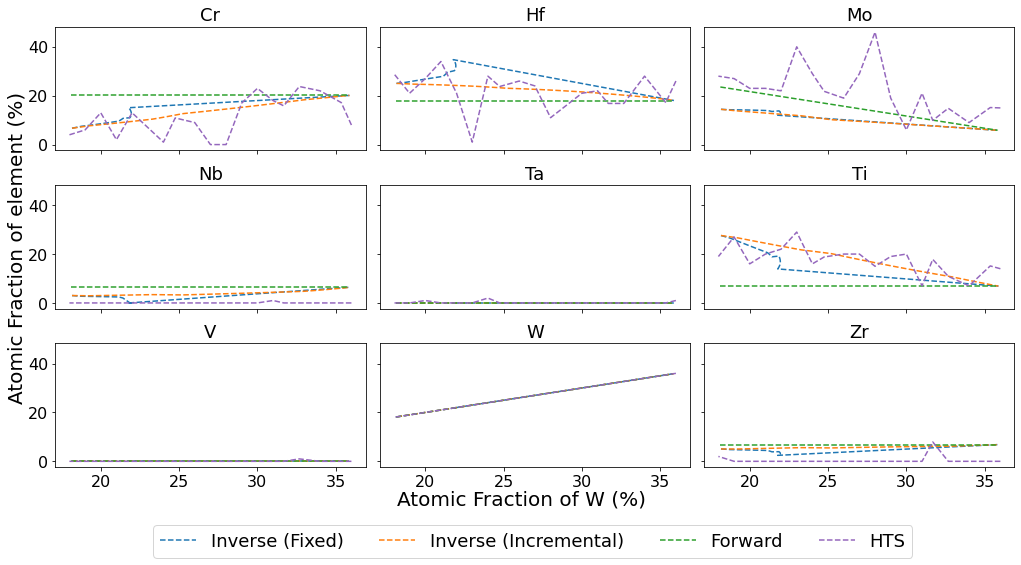

In [14]:
to_consider = results_dict['inverse']['constants']['to_consider']
inverse_comps_fixed = np.array(results_dict['inverse']['fixed']['g_fake_data'])
inverse_comps_inc = np.array(results_dict['inverse']['inc']['g_fake_data'])
forward_comps = np.array(results_dict['forward']['best_cands'])
hts_comps = np.array(hts_dict['all_comps'])
fig,ax = plt.subplots(3,3, figsize = (14,7), sharex = True, sharey=True)
ax = ax.flatten()
for k, el in enumerate(to_consider):
    i = np.argwhere(el_list==el).item()
    ax[k].plot(100*inverse_w_fixed, 100*inverse_comps_fixed[:,i], label = 'Inverse (Fixed)', linestyle = 'dashed')
    ax[k].plot(100*inverse_w_inc, 100*inverse_comps_inc[:,i], label = 'Inverse (Incremental)', linestyle = 'dashed')
    ax[k].plot(100*forward_w, 100*forward_comps[:,i], label = 'Forward', linestyle = 'dashed')
    ax[k].plot(100*hts_w, 100*hts_comps[:,i], label = 'HTS', linestyle = 'dashed', c =  'tab:purple')

    ax[k].set_title(el, fontsize = 18)
    ax[k].tick_params(axis='both', which='major', labelsize=16)
fig.text(-0.01, 0.5, 'Atomic Fraction of element (%)', va='center', rotation='vertical', fontsize = 20)
fig.text(0.5, -0.01, 'Atomic Fraction of W (%)', ha='center', fontsize = 20)
plt.tight_layout()
plt.legend(ncol = 4, bbox_to_anchor = (-0.3, -0.4, 1, 0), fontsize = 18)
plt.savefig(os.path.join(fig_location, 'at_frac_change.pdf'), bbox_inches="tight")